# Introduction

Recently I had to produce some plots showing a distribution of the charge that is induced by an ionizing particle passing through a gasesous detector. Such distribution is highly dependent on the electric field in the gas medium and the gas mixture itself. Since I am studying eco-friendly gas mixture for a particular kind of the detector I wanted to compare the charge distribution that the detectors have when operated with different gas mixture. In this context,
I initially though about overlapping the charge distributions, but there may be some features about the distribution that can easily get lost when plotting one histogram on top of the other.

In addition, I wanted to produce some histograms with a style consistent to the other plots that I usually make, so I am using my custom matplotlib stylesheet, as explained in my [previous blog post](../my-matplotlib-stylesheet/index.ipynb)

In order to show the issue that I had to fight with, I have prepared a `.csv` file containing two columns: one colum represents the charge that will be plotted
in the form of a histogram. The second column is categorical label indicating to which gas mixture the measured charge belongs to.

Also, I often use [seaborn](https://seaborn.pydata.org/) to help me produce these kind of plots.

Let me start by showing the different charge distributions:

In [60]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use('https://gitlab.cern.ch/-/snippets/2223/raw/master/rpcecogas.mplstyle')
df = pd.read_csv('charge_distribution.csv', index_col=0)

df.head()


,charge,label
0,2.521321,Standard
1,2.074056,Standard
2,1.207791,Standard
3,0.663411,Standard
4,0.618327,Standard


If I try to plot a histogram of `charge` with a color based on the `label` category I get this:

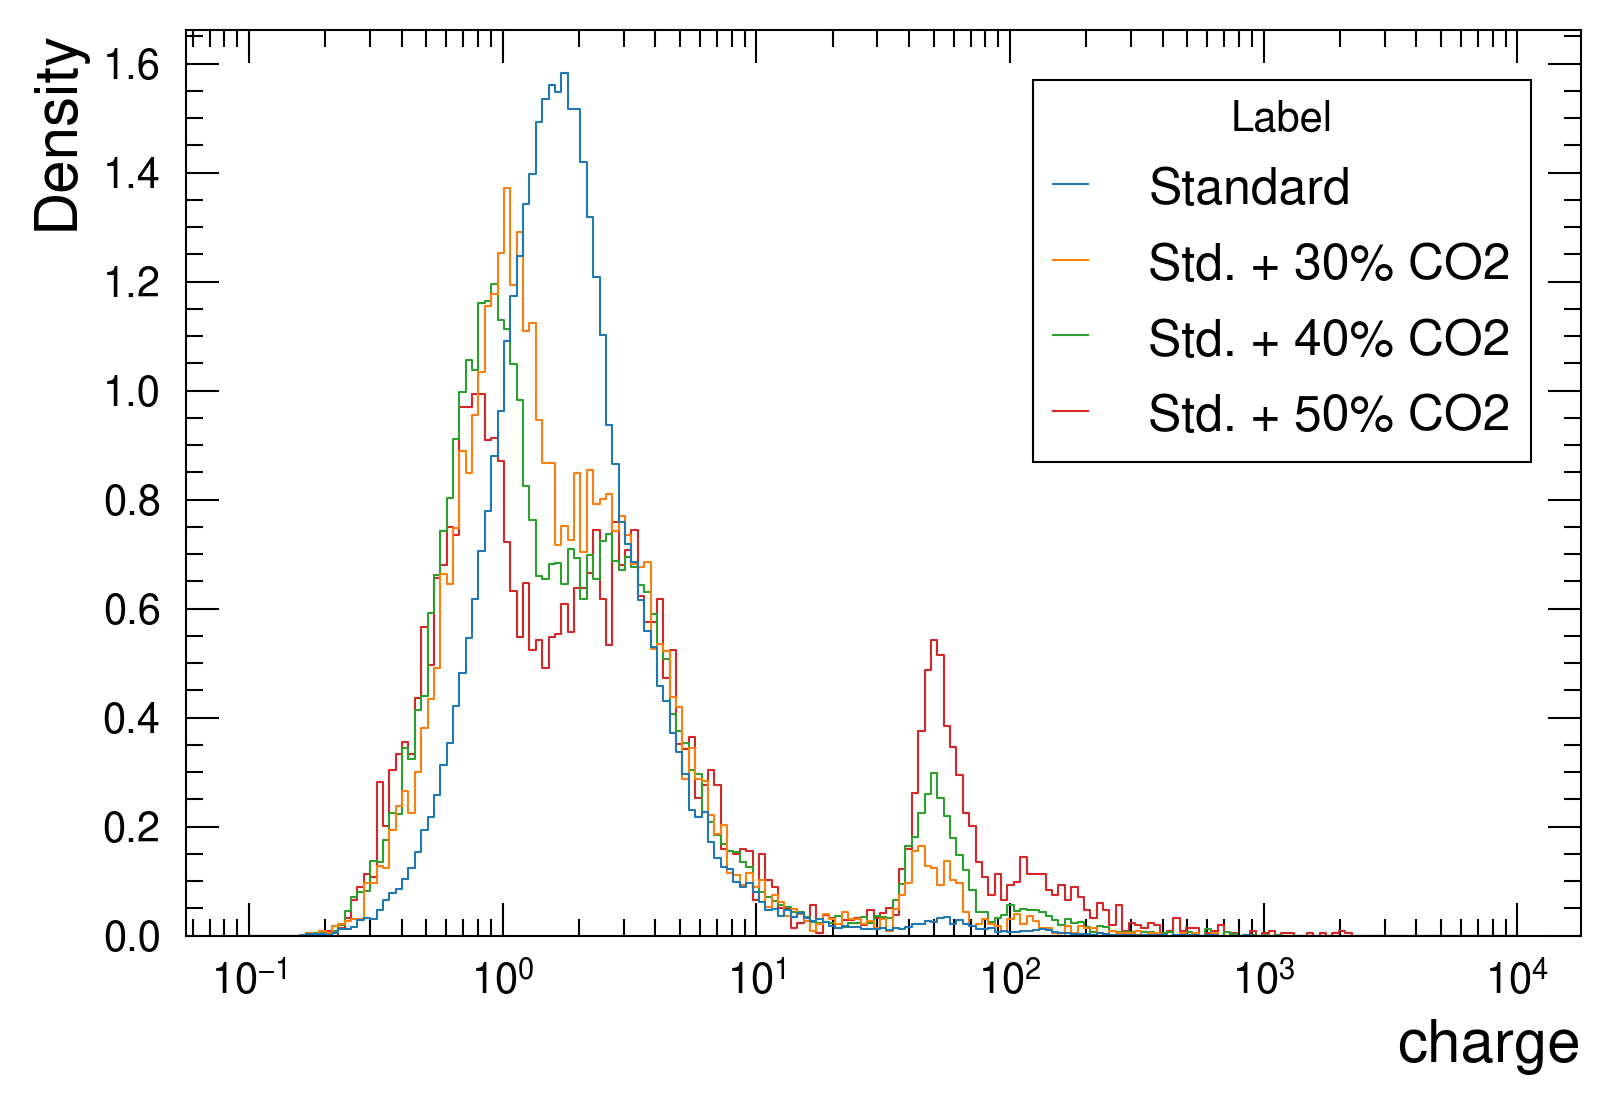

In [61]:
#| fig-label: fig-default-histogram
#| fig-cap: "Charge distribution of different gas mixtures"

ax = sns.histplot(data=df, x='charge', hue='label', log_scale=True, 
             stat='density', common_norm=False, element='step',
             bins=np.linspace(-1, 4, 200), fill=False)
ax.get_legend().set_title('Label')

The above plot was made using the seaborn `histplot()` function, using a logarithmic scale on the x axis. In this particular case one can see that the blue distribution has a nice, single, bell shape, while the other three distributions, which represent gas mixtures with the addition of CO$_2$ to the standard gas mixture, have a more complex behaviour. Although it looks clear that with an increase of CO$_2$ the region with a charge higher than 20 a.u. is increasing, the behaviour on lower region is difficult to understand due to the overlapping lines, especially in the region around 2 a.u. 

The idea was then to try to make a ridge plot, where the the histograms are shifted of a fixed offest along the y-axis. In this case, my starting point was a plot made with seaborn, although there are [plain matplotlib solutions](https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/).
The [seaborn documentation](https://seaborn.pydata.org/examples/kde_ridgeplot) on ridge plots suggests to use a `FacetGrid` object and make use of the method `FacetGrid.map` to use a seaborn drawing functions on top of the figure created by the `FacetGrid`. The `FacetGrid` object pass a `row` parameter which should contains the name of a column of the dataframe being used. The `row` parameter allows to create unique rows of plots depending on how many unique values the dataframe column has.

In addition, I also want the lines to be colored differently depending on the label, so I will also make use of the `hue` parameter.

By only using map I get this results:

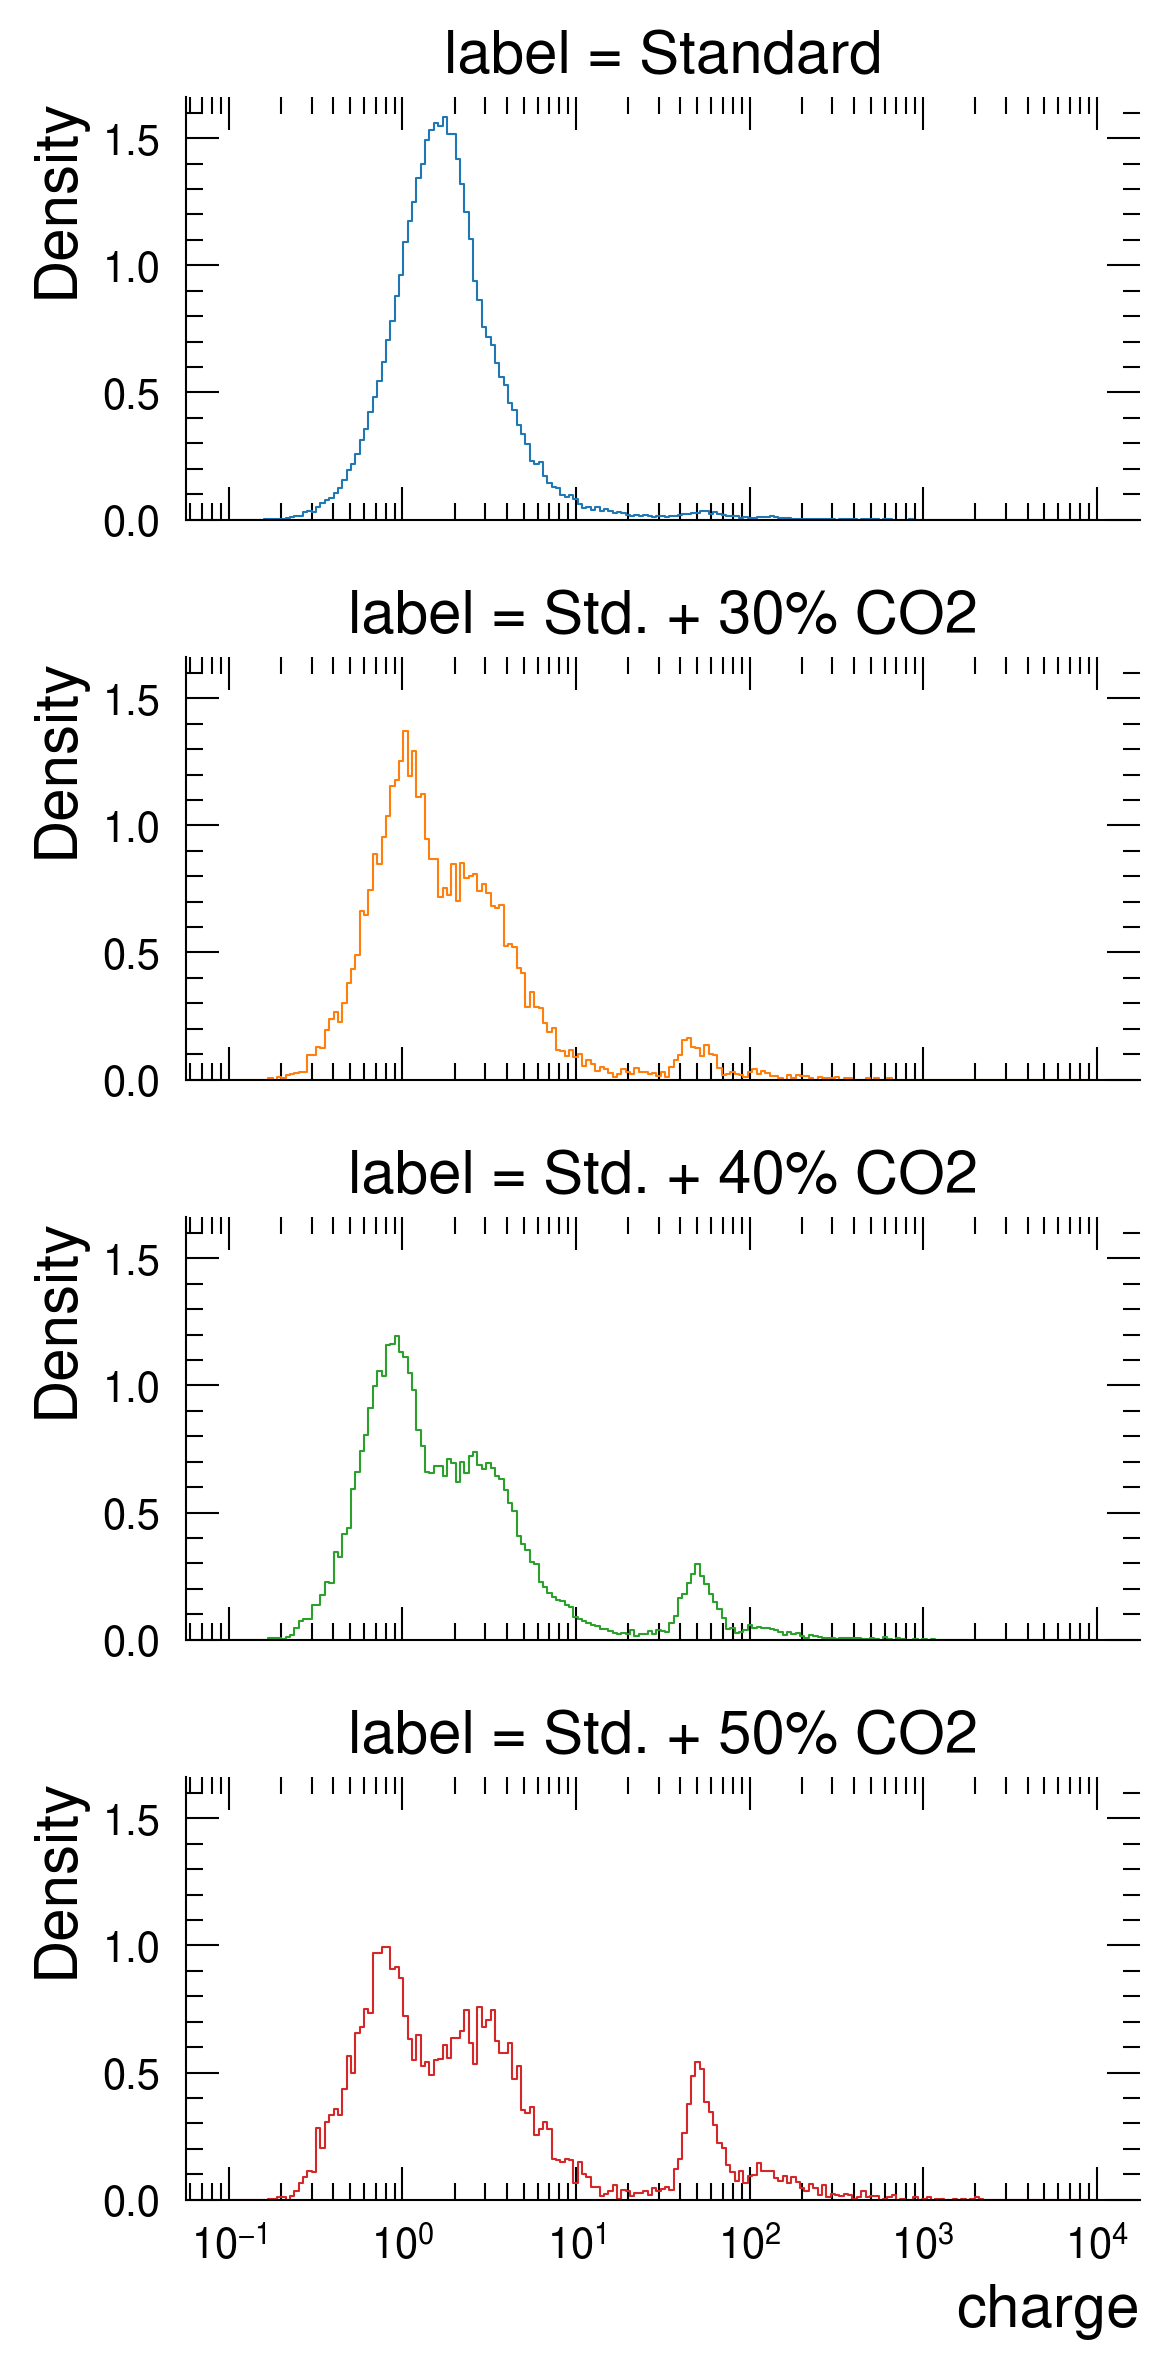

In [62]:
#| fig-label: fig-matplotlib-initial-ridgeplot
#| fig-caption: Using `FacetGrid` as a starting point for a ridge plot.

g = sns.FacetGrid(data=df, hue='label', row='label', aspect=2, height=2)
# Use the seaborn histplot() function to create histograms
# for each row. In this case I am passing the same
# arguments of the plot made before
g.map(sns.histplot, 'charge', log_scale=True, 
             stat='density', common_norm=False, element='step',
             bins=np.linspace(-1, 4, 200), fill=False)

This plot can be considered as an improvement with respect to @fig-default-histogram as it allows to clearly see the shape difference between the charge distributions. It is indeed possible to observe a a less sharp charge distribution in the last histogram (the red one) if compared to the previous one (the green house). 

The only downside of such a plot is its vertical space. There are axes frames, axes titles and ticks that eat up a significant amount of space. So in this case I would get rid of the top, bottom and left axes frames and titles, except for the last one:

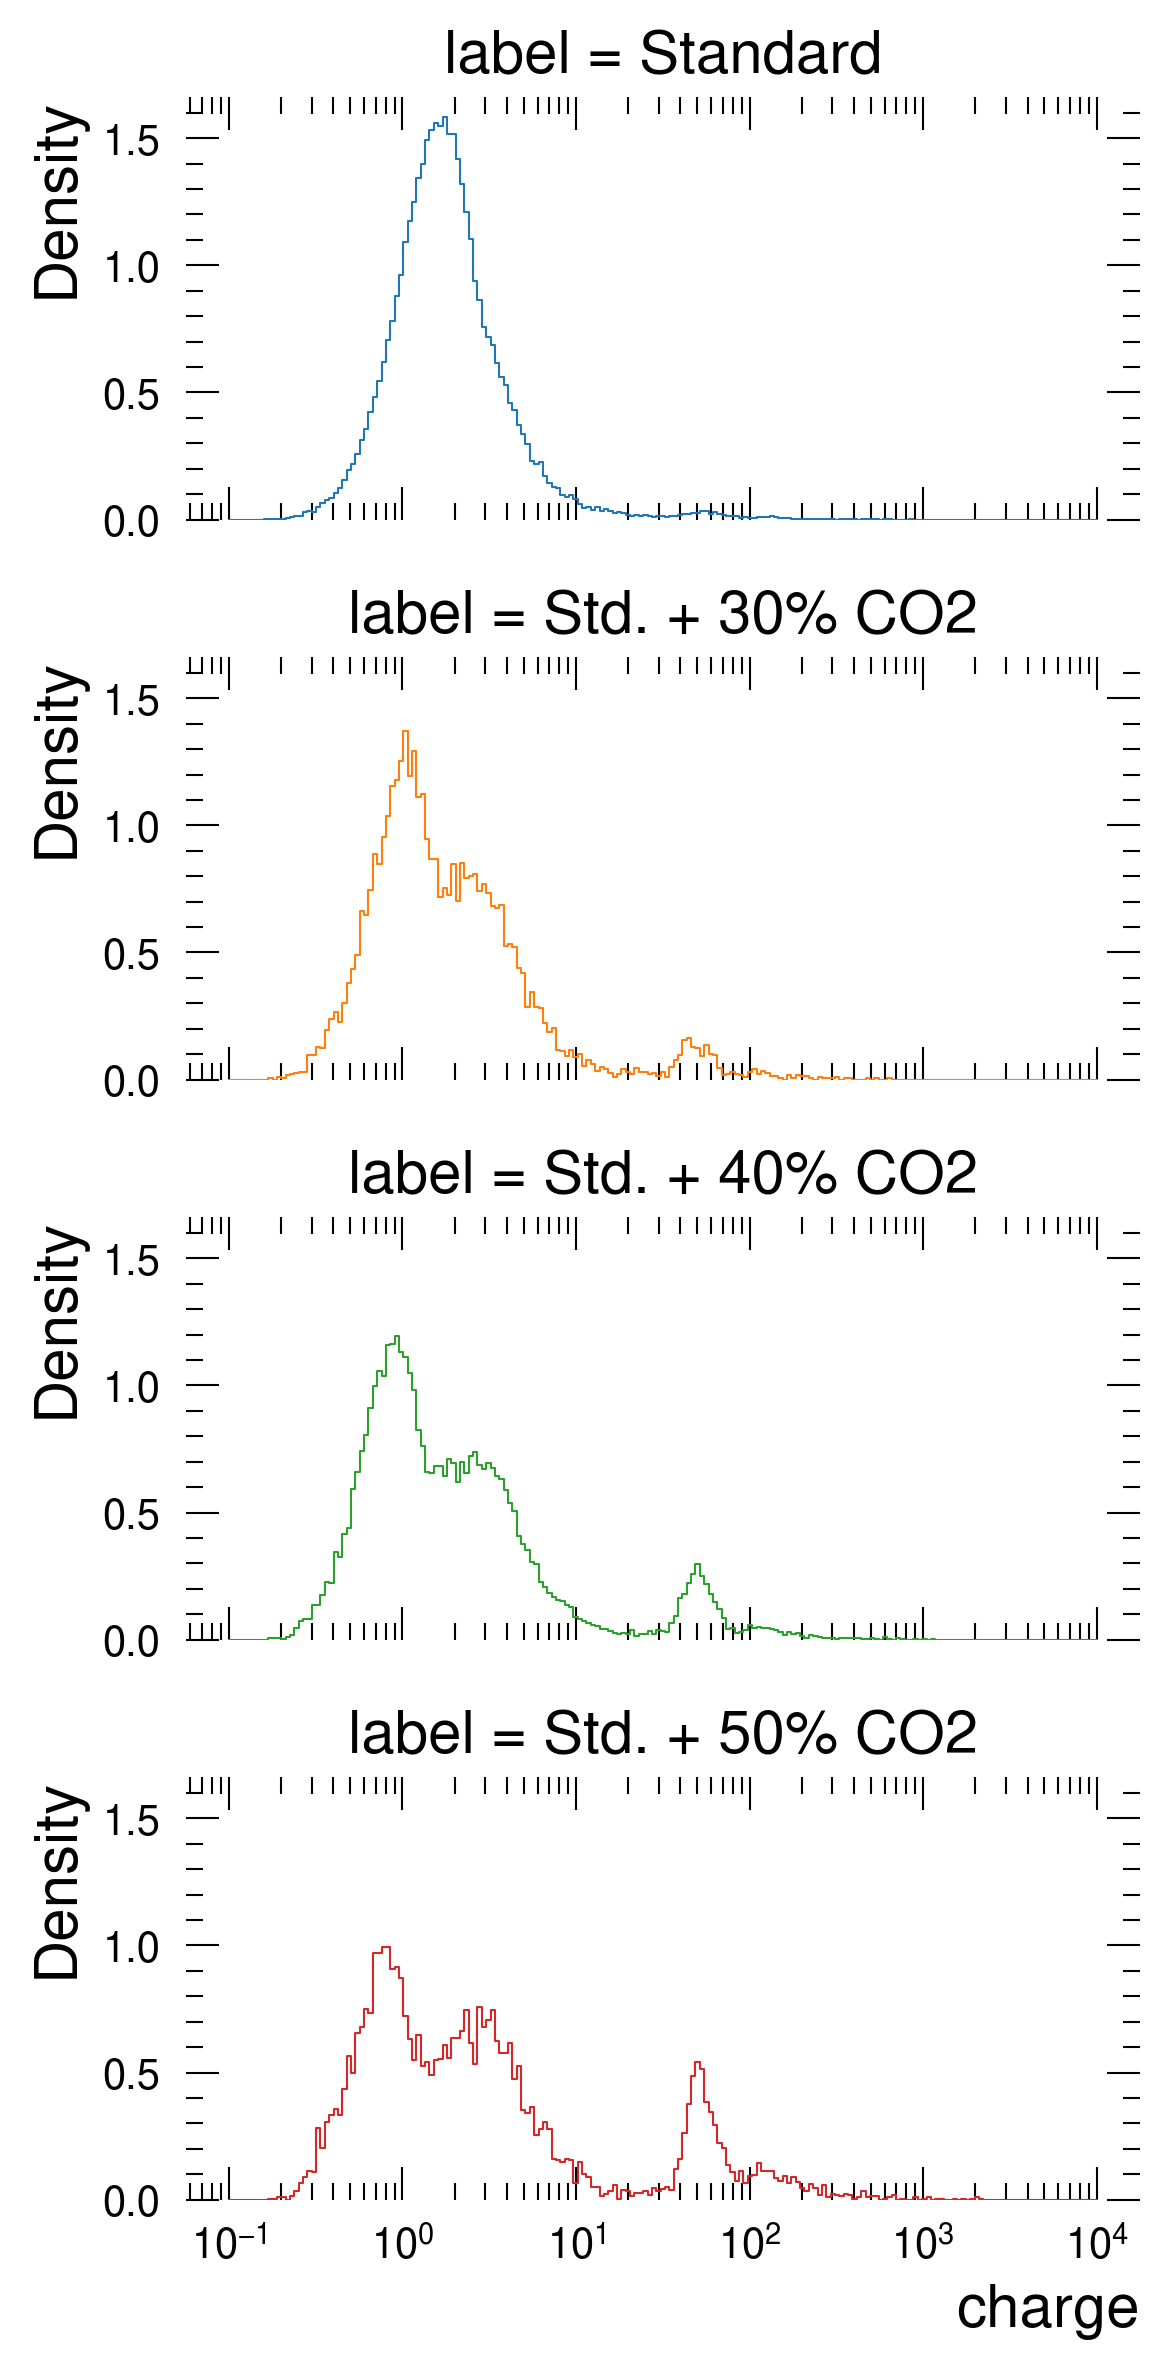

In [85]:
#| fig-label: fig-matplotlib-improved-ridgeplot
#| fig-caption: Removing axes frames

g = sns.FacetGrid(data=df, hue='label', row='label', aspect=2, height=2)
# Use the seaborn histplot() function to create histograms
# for each row. In this case I am passing the same
# arguments of the plot made before
g.map(sns.histplot, 'charge', log_scale=True, 
             stat='density', common_norm=False, element='step',
             bins=np.linspace(-1, 4, 200), fill=False)
# Remove all left, top and right frames
g.despine(left=True, top=True, bottom=True)

Now I would like to remove the ticks on the sides, bottom and top as I did for the frames. To do this, I would set the ticks length to 0 and the tick labels to an empty list:

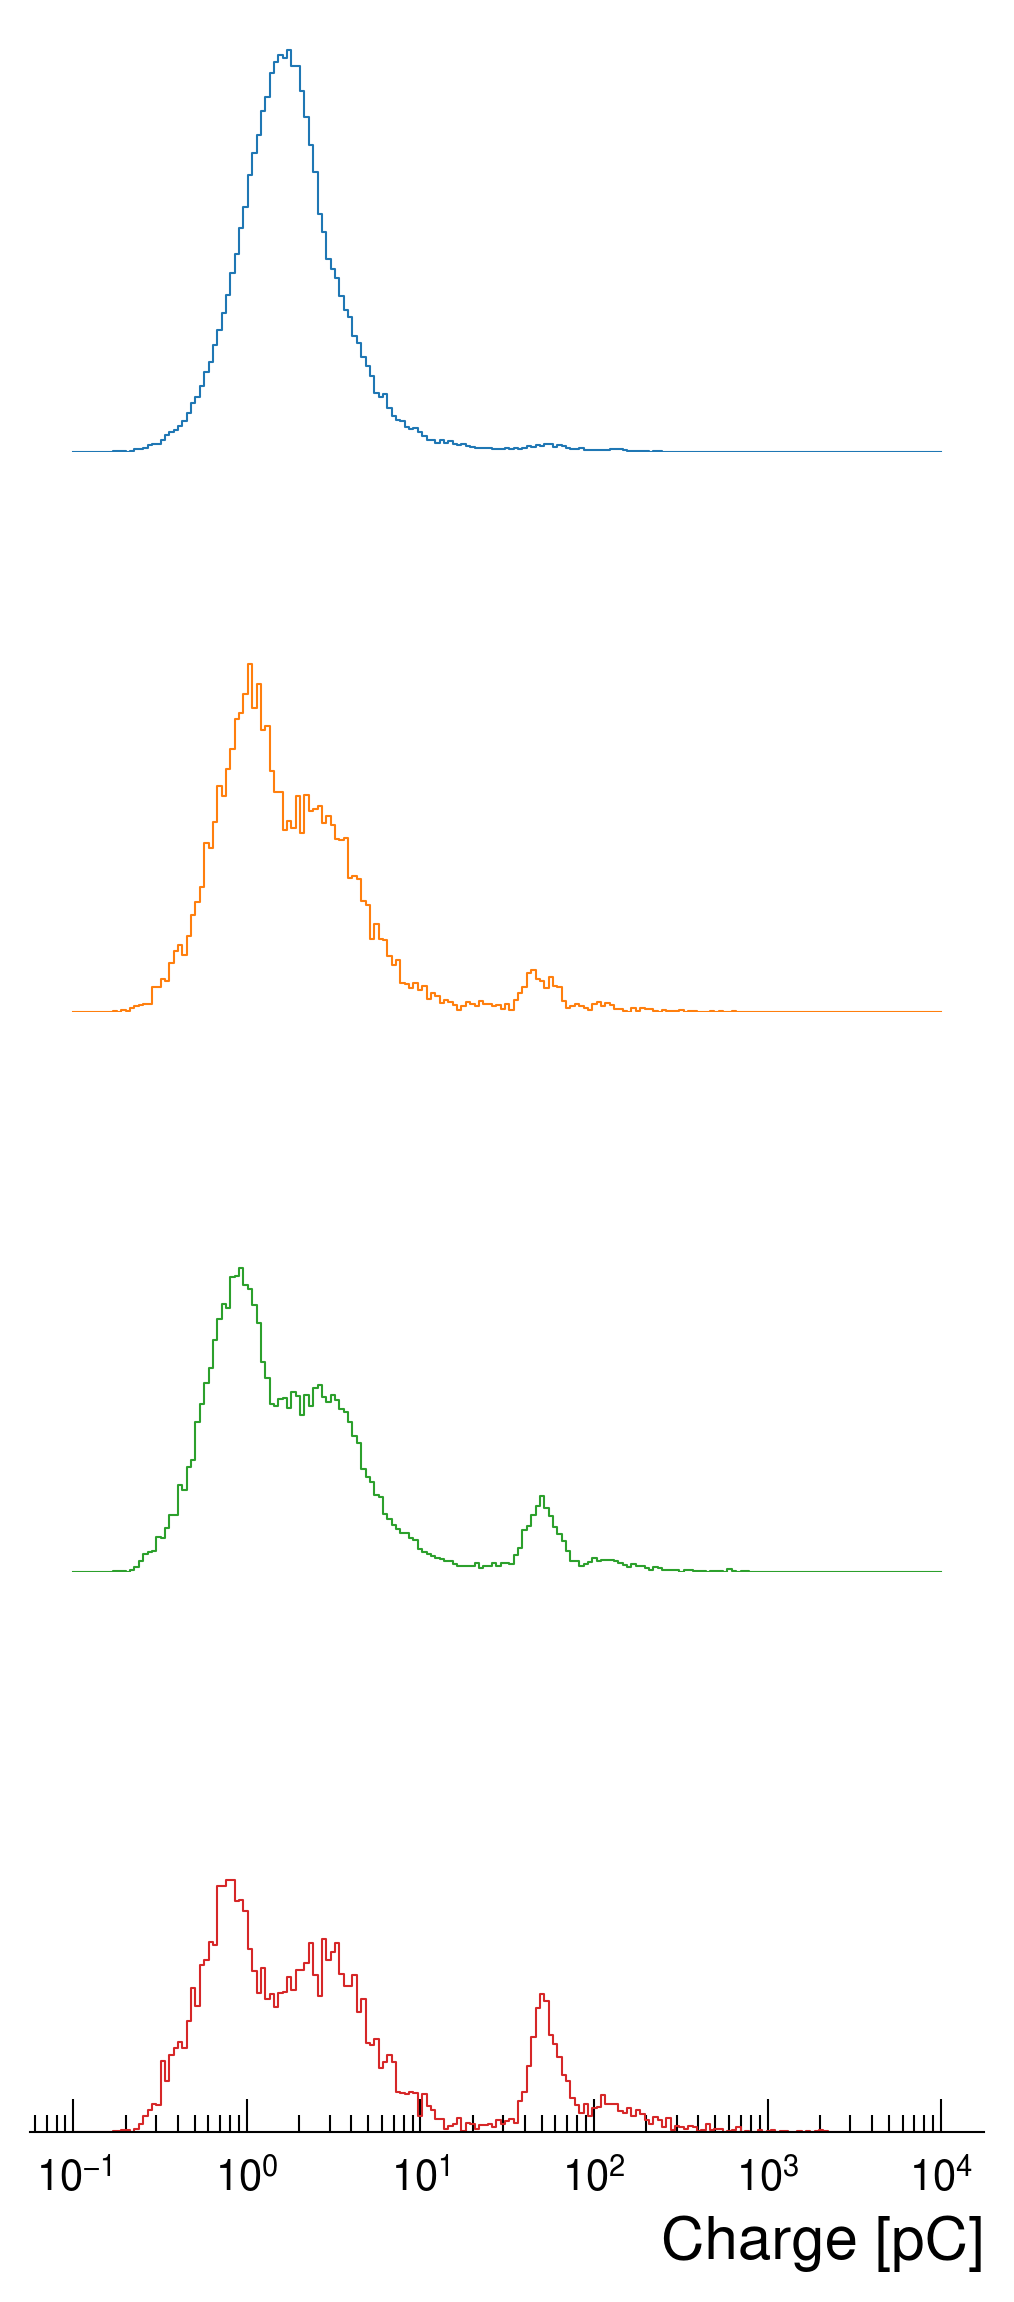

In [92]:
#| fig-label: fig-matplotlib-improved-ridgeplot-no-ticks
#| fig-caption: Removing ticks

# Adding a matplotlib rc_context to disable ticks
g = sns.FacetGrid(data=df, hue='label', row='label', aspect=2, height=2)
# Use the seaborn histplot() function to create histograms
# for each row. In this case I am passing the same
# arguments of the plot made before
g.map(sns.histplot, 'charge', log_scale=True, 
            stat='density', common_norm=False, element='step',
            bins=np.linspace(-1, 4, 200), fill=False)
# Remove all left, top and right frames
g.despine(left=True, top=True, bottom=True)
# Manually removing ticks
for ax in g.axes.ravel()[:-1]:
    # Remove ticks by settings their length to 0
    ax.tick_params(axis='both', length=0, which='both')

# Use seaborn to remove y labels and titles
g.set_axis_labels("Charge [pC]", "")
g.set_titles("")
# Remove y ticks from all axes
g.set(yticklabels=[])
# Remove the spines also on the last plot, except for the bottom one
last_ax = g.axes.flat[-1]
sns.despine(left=True, top=True, bottom=False, ax=g.axes.flat[-1])
# Use mpl apis to remove ticks
last_ax.tick_params(top=False, left=False, right=False, which='both')


Now, what is left is to get the distributions closer to each other and eventually add a label to each of them, indicating to which category they belong:

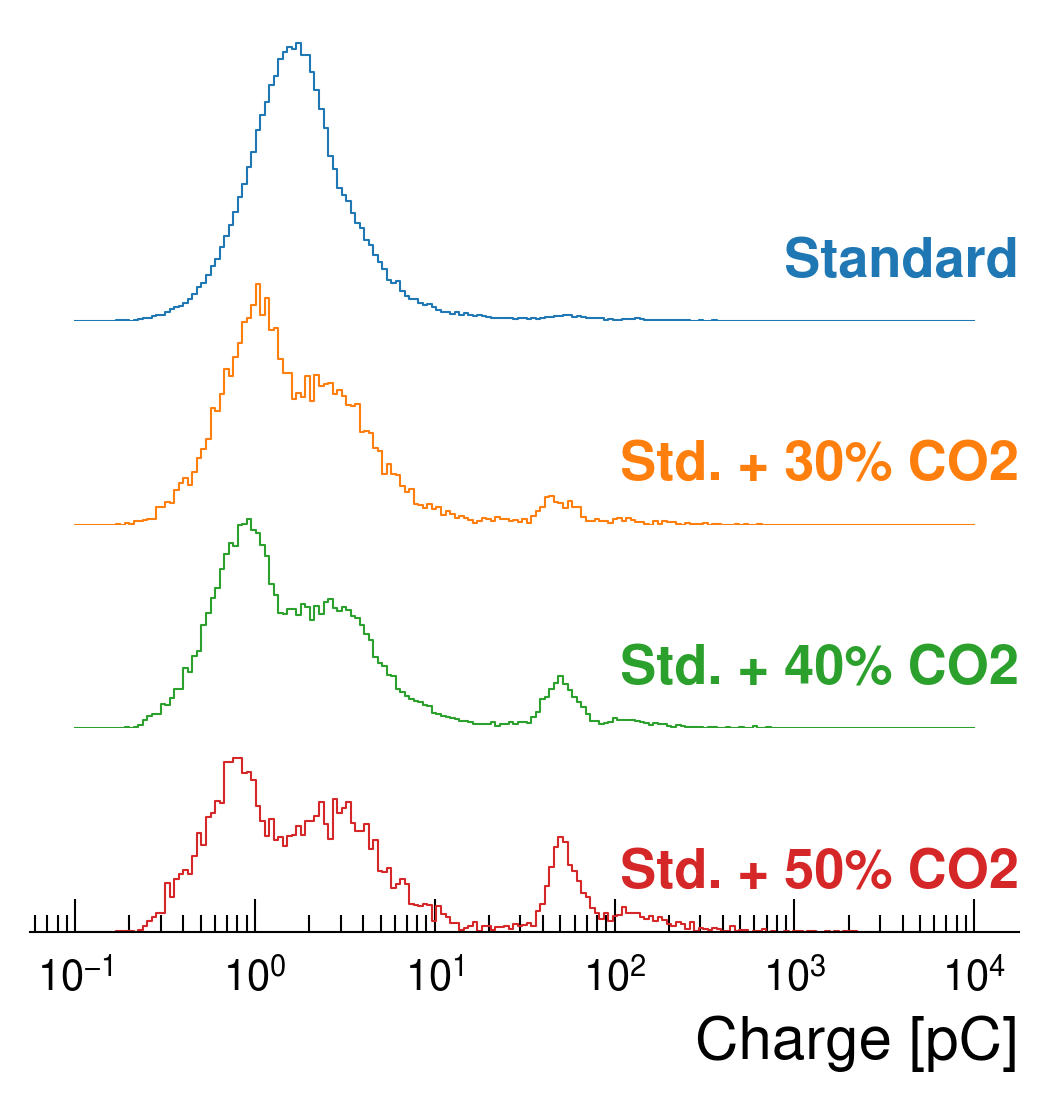

In [93]:
#| fig-label: fig-matplotlib-improved-ridgeplot-final
#| fig-caption: Final ridge plot

def add_label(x, color, label):
    """Add a label to each mapped category"""
    ax = plt.gca()
    # The position of the label depends on the figure size and layout.
    # For this reason, the x and y coordinates may need to be set manually.
    ax.text(1, .2, label, color=color, fontsize=13, fontweight='bold',
            ha="right", va="center", transform=ax.transAxes)

# Minor adjustment on aspect and height: use a large aspect for broad
# distributions and set height to 1 (this value depends also on the
# matplotlib's dpi resolution)
g = sns.FacetGrid(data=df, hue='label', row='label', aspect=4, height=1)

g.map(sns.histplot, 'charge', log_scale=True, 
            stat='density', common_norm=False, element='step',
            bins=np.linspace(-1, 4, 200), fill=False)

g.despine(left=True, top=True, bottom=True)

for ax in g.axes.ravel()[:-1]:
    ax.tick_params(axis='both', length=0, which='both')
    
# Map the label function to each 'hue' catgory of seaborn
g.map(add_label, "label")
# Make the subplots get close together by decreasing the horizontal space
g.fig.subplots_adjust(hspace=-0.4)

g.set_titles("")
g.set(yticklabels=[])
# For some seaborn internal reason, the set_titles() function
# should be called after the map function, otherwise the titles
# won't be removed
g.set_axis_labels("Charge [pC]", "")
last_ax = g.axes.flat[-1]
sns.despine(left=True, top=True, bottom=False, ax=last_ax)
last_ax.tick_params(top=False, left=False, right=False, which='both')

# Set a transparent facecolor, otherwise the white backround of a 
# subplot will cover the ones behind
g.set(facecolor=[0,0,0,0])
# Make the sublots closer by removing some horizontal space between
# them
g.fig.subplots_adjust(hspace=-0.3)

Et voilà, the plot is ready. What should be mentioned is that in this case I have combined both seaborn and matplotlib's API's, although I'm pretty sure there is a cleaner way with matplotlib APIs only.
For the code, there are few caveats that should be taken into account:

* The addition of a label is done by setting the coordinates relative to the subplots with hand-crafted values. I haven't found yet a better solution;
* The addition of a label using seaborn's `FacetGrid.map()` function should be done before setting titls and axes labels using seaborn `FacetGrid.set()`. I haven't digged down to see why to be honest, but if one first sets the titles to `""` and later uses the `map()` function the titles are coming back.
* The subplots should have a transparent face color. My default stylesheet has a white facecolor. If I don't change the facecolor, the subplots on the front will partially cover the ones in the back.

Also, one can notice that this kind of plot is providing some easier way to compare different distributions when they have different skeweness and shapes. 

# Conclusions

In this post I showed how I am using seaborn and matplotlib to create my own, publication-ready, ridge plot, which is at the end a simple overlapping of histograms with some additional styles applied. 
To sum up, the steps that I have applied to get this plot:

1. Despine everything if using seaborn
2. Set the xtick length to 0 for all the axes except the last one
3. Set all axes titles to "" and all `yticklabels` to an empty list
4. Re apply despine to leave the bottom spines for the last axis
5. Put back the bottom spine on the last axis using again `sns.despine()`
6. Remove ticks from top, left, right faces of the last axis
7. Set the facecolor of the axes to be transparent
8. Gets the subplots closer using `plt.subplots_adjust()` and a negative `hspace`

There may be a more straightforward way to do this and in that I case I would be glad to see it, but so far it is the only way I found to get a plot that does what I needed. I found this kind of visualization very interesting and a bit more easy to use in publications with respect to the ridge plots showed in other tutorials and documentations as it doesn't have any fill color on the distribution, it's consistent with the applied stylesheet and it is relatively uncluttured.
